In [1]:
from chp4_sur_CNN import SurnamesDataset, SurnamesVectorizer
import torch
from torch import nn
import torch.nn.functional as F
import pdb

In [2]:
filename = '../data/data/names/full_dataset.csv'
dataset = SurnamesDataset.load_dataset_and_make_vectorizer(filename)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda', index=0)

In [4]:
dataset.input_size()

87

In [5]:
dataset.output_size()

18

In [6]:
dataset.max_surname_len

20

In [7]:
dataset.get_item(0)

Unnamed: 0        5040
surname           Last
nationality    English
split            train
Name: 0, dtype: object

In [8]:
dataset._vectorizer.vectorize('Last', dataset.max_surname_len)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
dataset.head(2)

{'idx': 0, 'x_data': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'), 'y_target': tensor([0], device='cuda:0')}
{'idx': 1, 'x_data': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'), 'y_target': tensor([1], device='cuda:0')}


In [10]:
dataset[0]['x_data']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [11]:
import pdb
class SurnamesCNN(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size):
        
        super(SurnamesCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(input_vocab_size, 5))
        self.bn = nn.BatchNorm1d(num_features=32)
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.resnets = nn.ModuleList([
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1) for i in range(20)
        ])
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.cnn4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.fc = nn.Linear(256, output_vocab_size)
        
    def forward(self, input_vec, apply_softmax=True):
        #pdb.set_trace()
        hidden1 = self.bn(F.elu(self.cnn1(input_vec.unsqueeze(dim=1)).squeeze(dim=2)))
        hidden2 = F.dropout(F.elu(self.cnn2(hidden1)))
        hidden3_0 = hidden2
        for i, resnet in enumerate(self.resnets):
            hidden3_0 = resnet(hidden3_0) + hidden2
        hidden3 = F.dropout(F.elu(self.cnn3(hidden3_0)))
        hidden4 = F.elu(self.cnn4(hidden3))
        
        output = self.fc(hidden4.squeeze())
        if apply_softmax == True:
            output = torch.softmax(output, dim=0)
        return output

In [12]:
model = SurnamesCNN(dataset.input_size(), dataset.output_size()).to(device)

In [13]:
print(model)

SurnamesCNN(
  (cnn1): Conv2d(1, 32, kernel_size=(87, 5), stride=(1, 1))
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn2): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
  (resnets): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,)

In [14]:
x_data_from_dataset = next(iter(dataset))['x_data'].to(device)
y_target_from_dataset = next(iter(dataset))['y_target'].to(device)
x_data_from_dataset, y_target_from_dataset

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([0], device='cuda:0'))

In [15]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset=dataset, batch_size=4, 
                        drop_last=False, shuffle=True)

In [16]:
sample = next(iter(dataloader))
x_data = sample['x_data']
y_target = sample['y_target']
x_data, y_target

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [17]:
y_pred = model(x_data, apply_softmax=False)
print(y_pred)
print(y_target.view(-1))

tensor([[-0.0810,  0.0025,  0.0525, -0.1001,  0.1164,  0.0047,  0.0426, -0.0675,
          0.0274, -0.0446, -0.0295,  0.0139, -0.0726,  0.0194,  0.0707, -0.0218,
          0.0434,  0.0167],
        [-0.0569,  0.0904,  0.0121,  0.0788,  0.0505,  0.0085,  0.0370, -0.0084,
          0.0128,  0.1197, -0.1247,  0.0547, -0.0857,  0.0712,  0.0861, -0.0817,
         -0.0656,  0.0381],
        [-0.1371,  0.0819,  0.0077,  0.0380,  0.1275, -0.0490,  0.1095, -0.0078,
         -0.0109, -0.0146, -0.0286,  0.0241, -0.0394,  0.1112,  0.1218, -0.0644,
          0.0518,  0.0251],
        [-0.1082, -0.0457, -0.0337,  0.0057,  0.0028, -0.0770,  0.0246, -0.0347,
          0.0762,  0.0145,  0.0167,  0.0063, -0.0997,  0.0332,  0.0784,  0.0177,
         -0.0179,  0.0576]], device='cuda:0', grad_fn=<ThAddmmBackward>)
tensor([0, 1, 1, 0], device='cuda:0')


In [18]:
ce_loss = nn.CrossEntropyLoss()

In [19]:
ce_loss(y_pred, y_target.view(-1))

tensor(2.9034, device='cuda:0', grad_fn=<NllLossBackward>)

In [20]:
# Manual check:
sf_mx = torch.softmax(y_pred, dim=1)
torch.mean(-torch.log(torch.tensor([sf_mx[i, val.item()] for i, val in enumerate(y_target)])))

tensor(2.9034)

In [21]:
from torch.optim import Adam
from tqdm import tqdm as tqdm
import pdb

In [22]:
model = SurnamesCNN(dataset.input_size(), dataset.output_size()).to(device)
optim = Adam(params=model.parameters(), lr=0.001)

In [23]:
def run_batch(model, dataset, batch_type, batch_size, debug=False):
    
    if debug: pdb.set_trace()

    dataset.set_split(batch_type)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, 
                            drop_last=False, shuffle=True)

    running_loss = 0
    running_acc = 0

    if batch_type == 'train':
        model.train()
    else:
        model.eval()

    #for sample in tqdm(dataloader, desc='{:<{w}}'.format(batch_type, w=6)):
    for sample in dataloader:

        if model.training:
            model.zero_grad()

        x_data = sample['x_data']
        y_target = sample['y_target']

        y_pred = model(x_data, apply_softmax=False)
        loss = ce_loss(y_pred, y_target.view(-1))

        _, idx = torch.topk(torch.softmax(y_pred, dim=1), 1)
        acc = torch.sum(y_target == idx).float()

        if model.training:
            loss.backward()
            optim.step()

        running_loss += loss.to('cpu') * x_data.shape[0]
        running_acc += acc

    running_loss /= len(dataset)
    running_acc /= len(dataset)
    
    return round(running_loss.item(),4), round(running_acc.item(),4)

In [24]:
hist = []

In [25]:
num_epochs = 50
for epoch in range(num_epochs):
    tr_loss, tr_acc = run_batch(model, dataset, 'train', 528)
    val_loss, val_acc = run_batch(model, dataset, 'val', 256)
    print('{} / {} :'.format(epoch+1, num_epochs), (tr_loss, tr_acc), (val_loss, val_acc))
    hist.append([tr_loss, tr_acc, val_loss, val_acc])

1 / 50 : (2.0703, 0.4183) (2.2971, 0.4483)
2 / 50 : (1.5284, 0.5569) (1.9083, 0.5512)
3 / 50 : (1.3411, 0.6144) (1.4373, 0.598)
4 / 50 : (1.2052, 0.6444) (1.1824, 0.6707)
5 / 50 : (1.1031, 0.6735) (1.0942, 0.6737)
6 / 50 : (1.0245, 0.695) (1.0444, 0.6898)
7 / 50 : (0.9645, 0.7123) (1.0066, 0.7068)
8 / 50 : (0.9025, 0.7295) (0.9959, 0.7)
9 / 50 : (0.8557, 0.7424) (0.9372, 0.719)
10 / 50 : (0.8161, 0.7491) (0.9375, 0.718)
11 / 50 : (0.7875, 0.7585) (0.9286, 0.7151)
12 / 50 : (0.7587, 0.7693) (0.9229, 0.7268)
13 / 50 : (0.7245, 0.7766) (0.886, 0.7312)
14 / 50 : (0.6934, 0.7819) (0.9121, 0.7293)
15 / 50 : (0.6696, 0.7847) (0.8605, 0.7468)
16 / 50 : (0.6525, 0.7925) (0.8636, 0.7449)
17 / 50 : (0.6317, 0.7974) (0.8724, 0.741)
18 / 50 : (0.6275, 0.7995) (0.8734, 0.742)
19 / 50 : (0.5819, 0.814) (0.8589, 0.738)
20 / 50 : (0.5593, 0.8199) (0.8856, 0.7478)
21 / 50 : (0.5406, 0.8225) (0.882, 0.7322)
22 / 50 : (0.5245, 0.8295) (0.8786, 0.7532)
23 / 50 : (0.487, 0.8377) (0.8874, 0.739)
24 / 50 : (0

In [26]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
plt_hist = np.array(hist)

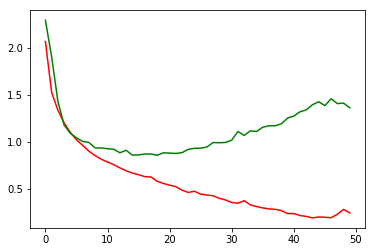

In [28]:
plt.plot(plt_hist[:,0], 'r', plt_hist[:,2], 'g')

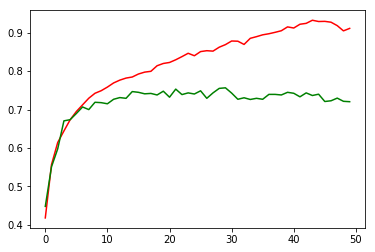

In [29]:
plt.plot(plt_hist[:,1], 'r', plt_hist[:,3], 'g')

In [30]:
run_batch(model, dataset, 'test', 512)

(1.4382, 0.7039)

In [31]:
def predict_nationality(surname):
    x_data = torch.tensor(dataset._vectorizer.vectorize(surname, 
                                                        dataset.max_surname_len)).float().unsqueeze(dim=0).to(device)
    y_pred = model(x_data, apply_softmax=True)
    probs, idx = y_pred.topk(5)
    topk = list(idx.squeeze().cpu().numpy())
    for i, k in enumerate(topk):
        print('{} {:2.0%}'.format(
            dataset._vectorizer.nationality_vocab.lookup_index(k),
            probs[i].item()))

In [32]:
torch.tensor(dataset._vectorizer.vectorize('Bagmevsky', dataset.max_surname_len)).float().unsqueeze(dim=0).shape

torch.Size([1, 87, 20])

In [33]:
predict_nationality('Bagmevsky')

Russian 100%
Czech 0%
German 0%
Polish 0%
Greek 0%


In [34]:
predict_nationality('O\'Neil')

Irish 100%
English 0%
French 0%
Scottish 0%
Spanish 0%


In [35]:
predict_nationality('Oliveira')

English 66%
Spanish 23%
Portuguese 11%
French 0%
Italian 0%
